In [ ]:
import math, shutil, os, time, argparse, json, re, sys
import numpy as np
import scipy.io as sio
from PIL import Image
import argparse
import os
import keras as k
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pandas as pd
import tensorflow as tf
from google.colab.patches import cv2_imshow
import math
from skimage.color import rgb2gray
from skimage.transform import resize
import shutil
import zipfile
import seaborn as sns
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from sklearn.model_selection import train_test_split
import cv2
import json
from keras.layers.pooling import MaxPooling2D
from keras.layers.core.activation import Activation
from keras.backend import conv2d
import tarfile


In [ ]:
for i in os.listdir('/content/drive/MyDrive/gazeMin.tar.gz/'):
  file = tarfile.open('/content/drive/MyDrive/gazeMin.tar.gz/'+i)
  file.extractall('/home/gaze')
  file.close()

In [ ]:
def makeGrid( params):
  gridSize=(25, 25)
  arrFrid = []
  for i in range(len(params)):
    gridLen = gridSize[0] * gridSize[1]
    grid = np.zeros([gridLen,], np.float32)
    indsY = np.array([i // gridSize[0] for i in range(gridLen)])
    indsX = np.array([i % gridSize[0] for i in range(gridLen)])
    condX = np.logical_and(indsX >= params[i][0], indsX < params[i][0] + params[i][2]) 
    condY = np.logical_and(indsY >= params[i][1], indsY < params[i][1] + params[i][3]) 
    cond = np.logical_and(condX, condY)
    grid[cond] = 1
    arrFrid.append(grid)
  arrFrid = np.array(arrFrid)
  return arrFrid

In [ ]:
minX = 0
minY = 0
def makeGaze(params,params2):
  minX = np.min(params)
  minY = np.min(params2)
  gridSize=(25, 25)
  for i in range(len(params)):
    params[i][0] = params[i][0]-minX
    params2[i][0] = params2[i][0]-minY
  return np.array(params),np.array(params2)

In [ ]:
def readJson(filename):
    if not os.path.isfile(filename):
        print('no es un archivo : ' , filename)
        return None

    with open(filename) as f:
        try:
            data = json.load(f)
        except:
            data = None

    if data is None:
        print('errores de lectura ' , filename)
        return None

    return data

In [ ]:
def cropImage(img, bbox):
    bbox = np.array(bbox, int)

    aSrc = np.maximum(bbox[:2], 0)
    bSrc = np.minimum(bbox[:2] + bbox[2:], (img.shape[1], img.shape[0]))

    aDst = aSrc - bbox[:2]
    bDst = aDst + (bSrc - aSrc)

    res = np.zeros((bbox[3], bbox[2], img.shape[2]), img.dtype)    
    res[aDst[1]:bDst[1],aDst[0]:bDst[0],:] = img[aSrc[1]:bSrc[1],aSrc[0]:bSrc[0],:]

    return res

In [ ]:
def main(dataset_path):
  #declarar variables para entrenamiento
    facesTrain = []
    eyesLeftTrain = []
    eyesRightTrain = []
    gridTrain = [] 
    xTrain = []
    yTrain = []

    facesTest = []
    eyesLeftTest = []
    eyesRightTest = []
    gridTest = [] 
    xTest = []
    yTest = []
    
    #recoge los datos de todas lals carpetas
    recordings = os.listdir(dataset_path)
    recordings = np.array(recordings, np.object)
    recordings = recordings[[os.path.isdir(os.path.join(dataset_path, r)) for r in recordings]]
    recordings.sort()
    #Se enumera cada una de las grabaciones
    for i,recording in enumerate(recordings):
        if i % 2 == 0:
          continue
        #Cada path de cada grabacion
        recDir = os.path.join(dataset_path, recording)
        #Lectura de datos validos
        appleFace = readJson(os.path.join(recDir, 'appleFace.json'))
        if appleFace is None:
            continue
        appleLeftEye = readJson(os.path.join(recDir, 'appleLeftEye.json'))
        if appleLeftEye is None:
            continue
        appleRightEye = readJson(os.path.join(recDir, 'appleRightEye.json'))
        if appleRightEye is None:
            continue
        dotInfo = readJson(os.path.join(recDir, 'dotInfo.json'))
        if dotInfo is None:
            continue
        faceGrid = readJson(os.path.join(recDir, 'faceGrid.json'))
        if faceGrid is None:
            continue
        frames = readJson(os.path.join(recDir, 'frames.json'))
        if frames is None:
            continue
        screen = readJson(os.path.join(recDir, 'screen.json'))
        if screen is None:
            continue
        #Valida los datos que estan seleccionados como validos
        validos = np.logical_and(np.logical_and(appleFace['IsValid'], appleLeftEye['IsValid']), np.logical_and(appleRightEye['IsValid'], faceGrid['IsValid']))
        if not np.any(validos):
            continue
        #Crea los frames y obtiene los frames de cada grabacion
        frames = np.array([int(re.match('(\d{5})\.jpg$', x).group(1)) for x in frames])
        bboxFromJson = lambda data: np.stack((data['X'], data['Y'], data['W'],data['H']), axis=1).astype(int)

        faceBbox = bboxFromJson(appleFace) + [-1,-1,1,1]
        leftEyeBbox = bboxFromJson(appleLeftEye) + [0,-1,0,0]
        rightEyeBbox = bboxFromJson(appleRightEye) + [0,-1,0,0]
        faceGridBbox = bboxFromJson(faceGrid)
        leftEyeBbox[:,:2] += faceBbox[:,:2] 
        rightEyeBbox[:,:2] += faceBbox[:,:2]


        for j,frame in enumerate(frames):
            # Can we use it?
            if screen['Orientation'][j] == 4:
              continue
            if not validos[j]:
                continue
            # Load image
            imgFile = os.path.join(recDir, 'frames', '%05d.jpg' % frame)
            if not os.path.isfile(imgFile):
                print('no existe la img en el path, img: ' , imgFile)
                continue
            img = Image.open(imgFile)        
            if img is None:
                print('no se puede abrir la img' , imgFile)
                continue
            img = np.array(img.convert('RGB'))
            #Recortar iamgenes
            imFace = cropImage(img, faceBbox[j,:])
            imEyeL = cropImage(img, leftEyeBbox[j,:])
            imEyeR = cropImage(img, rightEyeBbox[j,:])

            #Resize
            imFace = cv2.resize(imFace,(224,224),interpolation = cv2.INTER_AREA)
            imEyeL = cv2.resize(imEyeL,(180,180),interpolation = cv2.INTER_AREA)
            imEyeR = cv2.resize(imEyeR,(180,180),interpolation = cv2.INTER_AREA)

            if j % 3 == 0:
                #Guarda vairables para Test
                facesTest.append(imFace)
                eyesLeftTest.append(imEyeL)
                eyesRightTest.append(imEyeR)
                gridTest.append(faceGridBbox[j,:])
                xTest.append([dotInfo['XCam'][j]])
                yTest.append([dotInfo['YCam'][j]])
            else: 
                #Guarda vairables para Train
                facesTrain.append(imFace)
                eyesLeftTrain.append(imEyeL)
                eyesRightTrain.append(imEyeR)
                gridTrain.append(faceGridBbox[j,:])
                xTrain.append([dotInfo['XCam'][j]])
                yTrain.append([dotInfo['YCam'][j]])


    gridTest = np.stack(gridTest, axis = 0).astype(np.uint8)
    facesTest = np.array(facesTest)
    eyesLeftTest = np.array(eyesLeftTest)
    eyesRightTest = np.array(eyesRightTest)
    xTest = np.array(xTest)
    yTest = np.array(yTest)

    gridTrain = np.stack(gridTrain, axis = 0).astype(np.uint8)
    facesTrain = np.array(facesTrain)
    eyesLeftTrain = np.array(eyesLeftTrain)
    eyesRightTrain = np.array(eyesRightTrain)
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain)

    return facesTest,eyesLeftTest,eyesRightTest,gridTest,xTest,yTest,facesTrain,eyesLeftTrain,eyesRightTrain,gridTrain,xTrain,yTrain
  

In [ ]:
dataset_path = '/home/gaze'
facesTest,eyesLeftTest,eyesRightTest,gridTest,xTest,yTest,facesTrain,eyesLeftTrain,eyesRightTrain,gridTrain,xTrain,yTrain = main(dataset_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
print(np.min(xTrain),np.min(yTrain))
print(np.max(xTrain),np.max(yTrain))
print(np.min(xTest),np.min(yTest))
print(np.max(xTest),np.max(yTest))

-6.88542708333 -20.2546015625
20.2546015625 20.2546015625
-6.88542708333 -20.2546015625
20.2546015625 20.2546015625


Hacemos arrelo de la mirada

In [ ]:
xTrain, yTrain = makeGaze(xTrain, yTrain)
xTest, yTest = makeGaze(xTest, yTest)

In [ ]:
print(xTest.shape,yTest.shape)
print(xTrain.shape,yTrain.shape)

(3829, 1) (3829, 1)
(7616, 1) (7616, 1)


Ejemplo


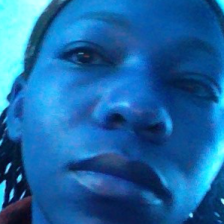

In [ ]:
cv2_imshow(facesTest[len(facesTest)-1])

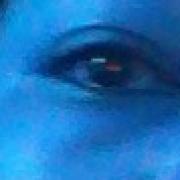

In [ ]:
cv2_imshow(eyesRightTest[len(facesTest)-1])

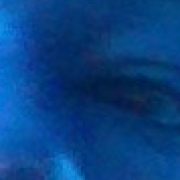

In [ ]:
cv2_imshow(eyesLeftTest[len(facesTest)-1])

Face

In [ ]:
faceModel = k.Sequential()

In [ ]:
faceModel.add(k.layers.InputLayer(input_shape = (224,224,3)))
faceModel.add(k.layers.BatchNormalization())

faceModel.add(Conv2D(32,(3,3),activation='relu'))
faceModel.add(Conv2D(32,(3,3),activation='relu'))
faceModel.add(MaxPooling2D((2,2)))

faceModel.add(Conv2D(64,(3,3),activation='relu'))
faceModel.add(Conv2D(64,(3,3),activation='relu'))
faceModel.add(MaxPooling2D((2,2)))

faceModel.add(Conv2D(128,(3,3),activation='relu'))
faceModel.add(Conv2D(128,(3,3),activation='relu'))
faceModel.add(Conv2D(128,(3,3),activation='relu'))
faceModel.add(Conv2D(128,(3,3),activation='relu'))
faceModel.add(MaxPooling2D((2,2)))


faceModel.add(k.layers.Dropout(0.4))

faceModel.add(Flatten())


Eyes

In [ ]:
eyesRigthModel = k.Sequential()

In [ ]:
eyesRigthModel.add(k.layers.InputLayer(input_shape = (180,180,3)))
eyesRigthModel.add(k.layers.BatchNormalization())

eyesRigthModel.add(Conv2D(32,(3,3),activation='relu'))
eyesRigthModel.add(Conv2D(32,(3,3),activation='relu'))
eyesRigthModel.add(MaxPooling2D((2,2)))

eyesRigthModel.add(Conv2D(64,(3,3),activation='relu'))
eyesRigthModel.add(Conv2D(64,(3,3),activation='relu'))
eyesRigthModel.add(MaxPooling2D((2,2)))

eyesRigthModel.add(k.layers.Dropout(0.4))
eyesRigthModel.add(Flatten())


In [ ]:
eyesLeftModel = k.Sequential()

In [ ]:
eyesLeftModel.add(k.layers.InputLayer(input_shape = (180,180,3)))
eyesLeftModel.add(k.layers.BatchNormalization())

eyesLeftModel.add(Conv2D(32,(3,3),activation='relu'))
eyesLeftModel.add(Conv2D(32,(3,3),activation='relu'))
eyesLeftModel.add(MaxPooling2D((2,2)))

eyesLeftModel.add(Conv2D(64,(3,3),activation='relu'))
eyesLeftModel.add(Conv2D(64,(3,3),activation='relu'))
eyesLeftModel.add(MaxPooling2D((2,2)))

eyesLeftModel.add(k.layers.Dropout(0.4))
eyesLeftModel.add(Flatten())


Concatenar redes neuronales

In [ ]:
eyes = k.layers.concatenate([eyesRigthModel.output, eyesLeftModel.output], axis=-1)
eyes = Flatten()(eyes)
eyesModel = k.Model(inputs=[eyesRigthModel.input, eyesLeftModel.input], outputs=eyes)

In [ ]:
total = k.layers.concatenate([faceModel.output, eyesModel.output], axis=-1)
total = Dense(128+64+128, activation='relu')(total)
total = Dense(2, activation='relu')(total)
model = k.Sequential()
model = k.Model(inputs=[faceModel.input,eyesModel.input], outputs=total)


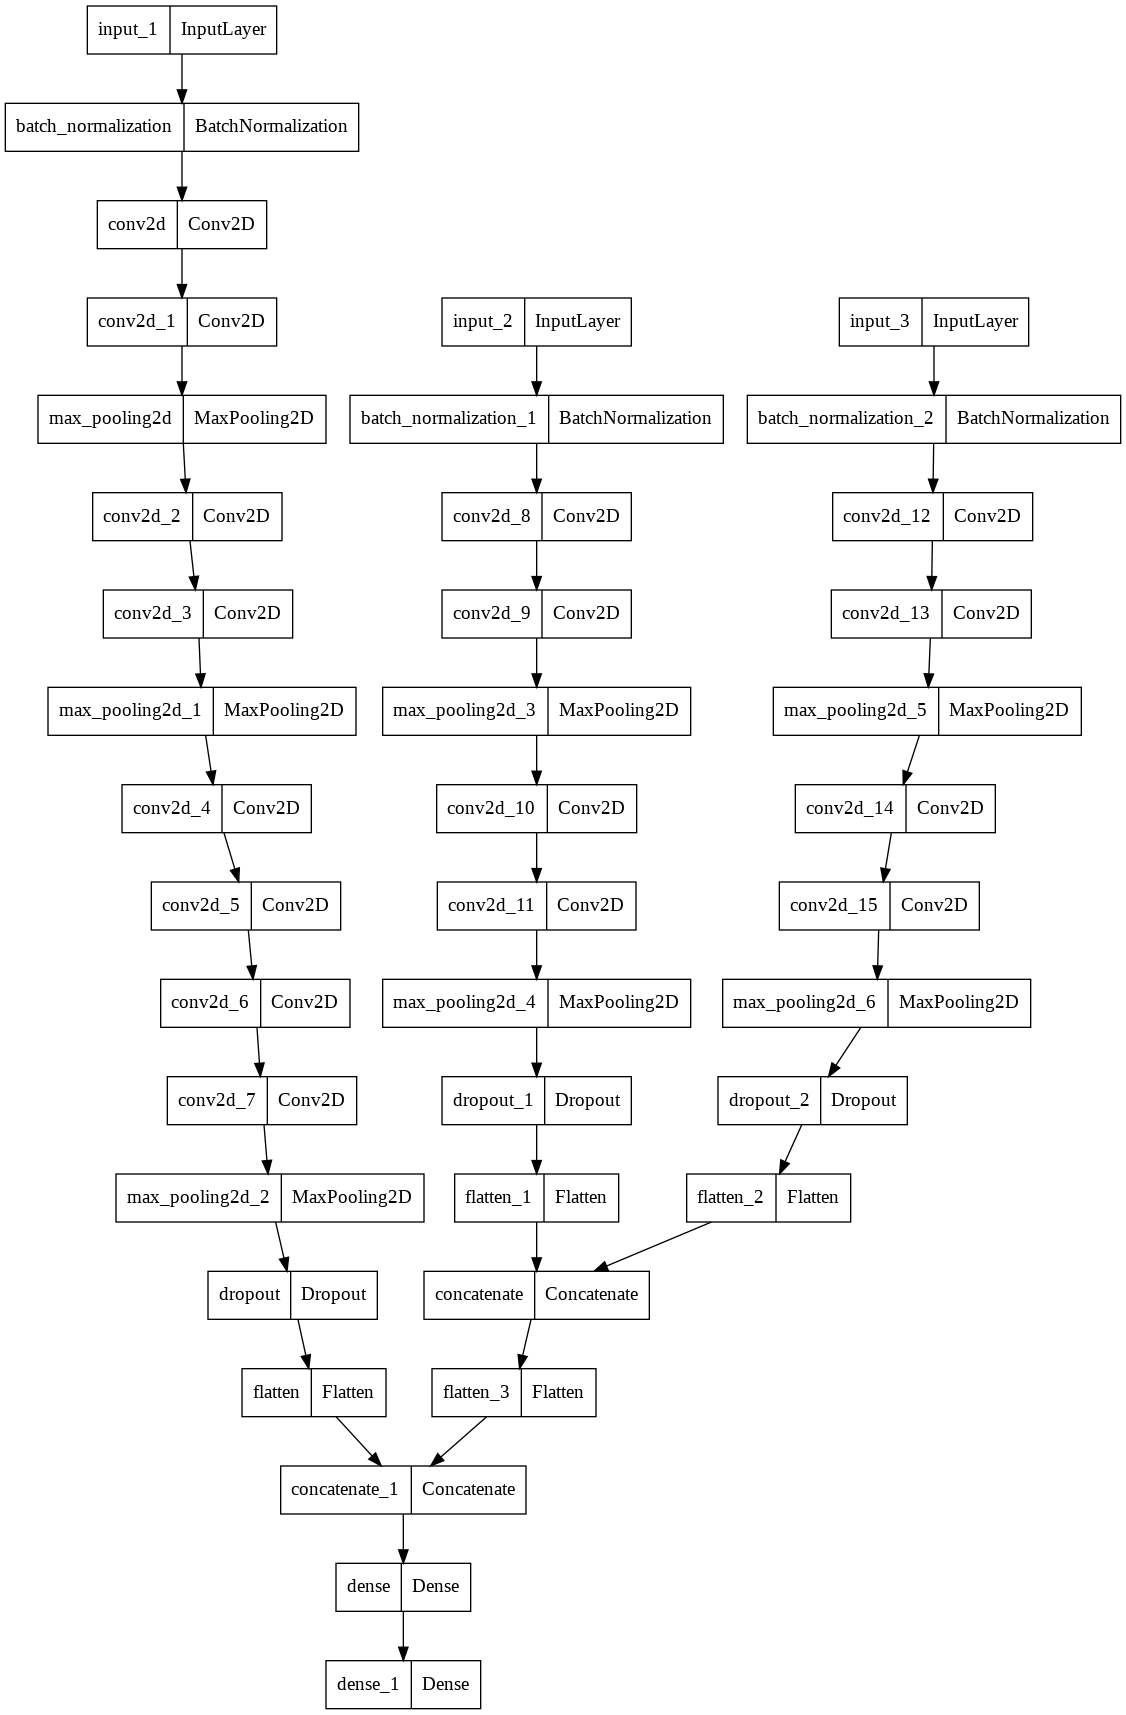

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
print(facesTest.shape,eyesRightTest.shape,eyesLeftTest.shape,xTest.shape,yTest.shape,gridTest.shape)
print(facesTrain.shape,eyesRightTrain.shape,eyesLeftTrain.shape,xTrain.shape,yTrain.shape,gridTrain.shape)

(3829, 224, 224, 3) (3829, 180, 180, 3) (3829, 180, 180, 3) (3829, 1) (3829, 1) (3829, 4)
(7616, 224, 224, 3) (7616, 180, 180, 3) (7616, 180, 180, 3) (7616, 1) (7616, 1) (7616, 4)


In [ ]:
lr = 0.0001
momentum = 0.9
opt = tf.keras.optimizers.SGD(lr,momentum)
model.compile(loss = "MSE", optimizer = opt)

In [ ]:
model.fit(x=[facesTrain,eyesRightTrain,eyesLeftTrain],y=[xTrain,yTrain],validation_data=([facesTest,eyesRightTest,eyesLeftTest],[xTest,yTest]),epochs=20) 

Epoch 1/20
238/238 [==============================] - 96s 340ms/step - loss: 22.4657 - val_loss: 17.5947
Epoch 2/20
238/238 [==============================] - 78s 328ms/step - loss: 14.7439 - val_loss: 11.3230
Epoch 3/20
238/238 [==============================] - 78s 328ms/step - loss: 11.2128 - val_loss: 9.2002
Epoch 4/20
238/238 [==============================] - 78s 329ms/step - loss: 9.2554 - val_loss: 9.8522
Epoch 5/20
238/238 [==============================] - 78s 328ms/step - loss: 8.1539 - val_loss: 7.0020
Epoch 6/20
238/238 [==============================] - 78s 328ms/step - loss: 7.0837 - val_loss: 6.8660
Epoch 7/20
238/238 [==============================] - 78s 328ms/step - loss: 6.3061 - val_loss: 6.2537
Epoch 8/20
238/238 [==============================] - 78s 329ms/step - loss: 5.7918 - val_loss: 6.2205
Epoch 9/20
238/238 [==============================] - 78s 328ms/step - loss: 5.2129 - val_loss: 5.3989
Epoch 10/20
238/238 [==============================] - 78s 328ms/ste

In [ ]:
print(model.history.history)

{'loss': [22.465728759765625, 14.74389362335205, 11.212797164916992, 9.255428314208984, 8.153882026672363, 7.083719253540039, 6.306098461151123, 5.791764259338379, 5.212852954864502, 4.6760334968566895, 4.4217987060546875, 4.131036281585693, 3.619969367980957, 3.6735782623291016, 3.2255687713623047, 2.857877254486084, 2.842449903488159, 2.617635726928711, 2.4189236164093018, 2.363477945327759], 'val_loss': [17.594715118408203, 11.322988510131836, 9.200224876403809, 9.85218620300293, 7.001995086669922, 6.866001605987549, 6.253708362579346, 6.2205281257629395, 5.39894437789917, 5.169591903686523, 5.716189384460449, 5.000070095062256, 4.514473915100098, 4.615468502044678, 4.2005934715271, 4.56223201751709, 4.687885761260986, 3.9127750396728516, 4.7374677658081055, 3.8945157527923584]}


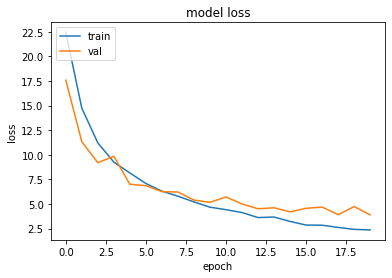

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#model.save('/content/drive/MyDrive/modelOnlyh4Log.h5')

In [ ]:
model = k.models.load_model('/content/drive/MyDrive/modelOnlyh4.h5')

In [ ]:
gaze_predicte = model.predict([facesTest,eyesRightTest,eyesLeftTest])

In [ ]:
auxPredicted = np.transpose((gaze_predicte))

In [ ]:
gazeTest = [xTest,yTest]

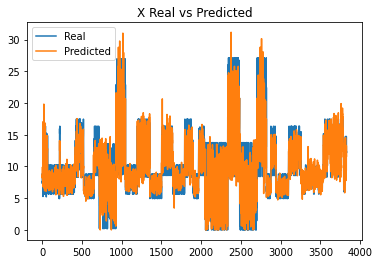

In [ ]:
plt.title("X Real vs Predicted")
plt.plot(xTest)
plt.plot(auxPredicted[0])
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()


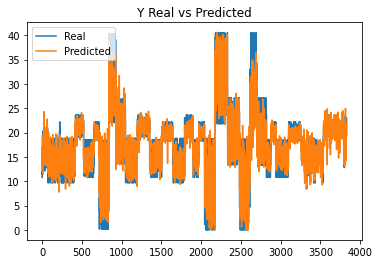

In [ ]:
plt.title("Y Real vs Predicted")
plt.plot(yTest)
plt.plot(auxPredicted[1])
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

In [ ]:
def calcMSE(x1,x2,y1,y2):
    return np.sqrt(np.square(x1-x2)+np.square(y1-y2))

In [ ]:
def calcAbs(x1,x2,y1,y2):
    return abs((x1-x2)+(y1-y2))

In [ ]:
gaze_predicte[i][0].min()
gaze_predicte[i][1].min()

21.584497

In [ ]:
arrayMSE = []
arrayABS = []
for i in range(len(gaze_predicte)):
  arrayMSE.append(calcMSE(gazeTest[0][i],gaze_predicte[i][0],gazeTest[1][i],gaze_predicte[i][1]))
  print("i : ",i," MSE : ",calcMSE(gazeTest[0][i],gaze_predicte[i][0],gazeTest[1][i],gaze_predicte[i][1]), " ABS : ",calcAbs(gazeTest[0][i],gaze_predicte[i][0],gazeTest[1][i],gaze_predicte[i][1]), gazeTest[0][i],gaze_predicte[i][0],gazeTest[1][i],gaze_predicte[i][1])
  arrayABS.append(calcAbs(gazeTest[0][i],gaze_predicte[i][0],gazeTest[1][i],gaze_predicte[i][1]))
arrayMSE = np.array(arrayMSE)
arrayABS = np.array(arrayABS)

i :  0  MSE :  [8.54155507]  ABS :  [8.32810706] [8.82417708] 8.613332 [10.78715086] 19.326103
i :  1  MSE :  [1.4117427]  ABS :  [0.59675903] [8.82417708] 8.16994 [10.78715086] 12.038147
i :  2  MSE :  [3.12685117]  ABS :  [4.24153229] [7.31403843] 8.809545 [13.96237076] 16.708397
i :  3  MSE :  [1.84492864]  ABS :  [2.59929765] [7.66767542] 9.080434 [11.33587784] 12.522417
i :  4  MSE :  [5.12517934]  ABS :  [6.85633481] [7.66767542] 9.920513 [11.33587784] 15.939375
i :  5  MSE :  [3.35684846]  ABS :  [4.51850326] [7.50597025] 9.037212 [14.17850462] 17.165766
i :  6  MSE :  [0.6264837]  ABS :  [0.66373388] [7.50597025] 7.4675403 [14.17850462] 13.553201
i :  7  MSE :  [2.32643388]  ABS :  [1.96759677] [8.08697437] 8.4216175 [16.66344119] 14.361201
i :  8  MSE :  [7.29318317]  ABS :  [9.01960434] [8.82417708] 6.8157635 [18.55305227] 11.541862
i :  9  MSE :  [1.11166708]  ABS :  [1.47291245] [8.82417708] 8.3625555 [18.55305227] 17.541761
i :  10  MSE :  [12.2154869]  ABS :  [15.02590333

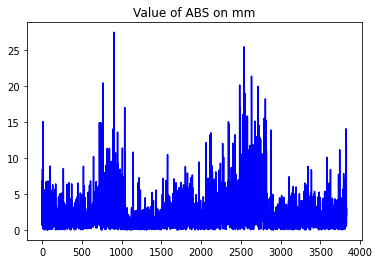

In [ ]:
plt.title("Value of ABS on mm")
plt.plot(np.arange(len(arrayABS)), arrayABS, color="blue")
plt.show()

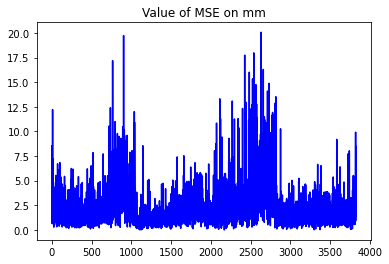

In [ ]:
plt.title("Value of MSE on mm")
plt.plot(np.arange(len(arrayMSE)), arrayMSE, color="blue")
plt.show()

In [ ]:
print(arrayABS.mean())

2.296579099179353


In [ ]:
print(arrayMSE.mean())

2.4099198979896803
